# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any LGAs over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', None)

In [31]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [32]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
seifa = seifa[seifa.LGA_2011.astype(str).str[0] == '4']
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()


<ipython-input-32-6f2dcf7d9dd4>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()


,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
1228,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1036,ADELAIDE
1229,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,909,ADELAIDE
1230,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1141,ADELAIDE
1231,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,19606,ADELAIDE
1232,40120,Adelaide Hills (DC),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1077,ADELAIDE HILLS


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [33]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874,874,1036,1013,19606
ADELAIDE HILLS,1083,1083,1077,1081,38601
ALEXANDRINA,1000,1000,969,987,23693
ANANGU PITJANTJATJARA,623,623,672,593,2433
BAROSSA,1028,1028,997,1017,22174


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [34]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [35]:
grouped = sa_vouchers.groupby(['Voucher_Sport','Participant_LGA'])['Voucher_Sport'].agg(['count'])
print('maximum participants enrolled in which voucher sport and they from which LGA'
      ,grouped.idxmax(),grouped.max())

maximum participants enrolled in which voucher sport and they from which LGA count    (Australian Rules, ONKAPARINGA)
dtype: object count    5258
dtype: int64


We can observe there are maximum 5258 participants from ONKAPARINGA and all them are enrolled with Australian Rules sports.


In [36]:
grouped_1 = sa_vouchers.groupby(sa_vouchers.Voucher_Claim_Year)
for Voucher_Claim_Year, Voucher_Claim_Year_sa_vouchers in grouped_1:
    print(Voucher_Claim_Year)

#grouped the dataset with respect to Voucher_claim_year

2015
2016
2017


In [37]:
g1 = grouped_1.get_group(2015)
g2 = g1.groupby(g1.Voucher_Sport)
g3 = g2.Participant_LGA.value_counts()
print(g3[g3 == g3.min()])
print(g3[g3 == g3.max()])

# for group 2015 grouping the dataset with Voucher_Sport.

Voucher_Sport      Participant_LGA               
Archery            HOLDFAST BAY                      1
                   VICTOR HARBOR                     1
Athletics          BARUNGA WEST                      1
                   CLARE AND GILBERT VALLEYS         1
                   FLINDERS RANGES                   1
                   MOUNT REMARKABLE                  1
                   ROXBY DOWNS                       1
BMX                ADELAIDE HILLS                    1
                   BAROSSA                           1
                   WAKEFIELD                         1
                   WEST TORRENS                      1
Badminton          VICTOR HARBOR                     1
Baseball           GRANT                             1
                   MOUNT BARKER                      1
Basketball         MOUNT REMARKABLE                  1
                   YANKALILLA                        1
Bowls              MARION                            1
Calisthenics   

Above is the data for 2015. It shows the maximum and minimum number of students enrolled in Voucher_sports and from which LGA.

In [38]:
g4 = grouped_1.get_group(2016)
g5 = g4.groupby(g4.Voucher_Sport)
g6 = g5.Participant_LGA.value_counts()
print(g6[g6 == g6.min()])
print(g6[g6 == g6.max()])

# for group 2016 grouping the dataset with Voucher_Sport.

Voucher_Sport      Participant_LGA               
Archery            CHARLES STURT                     1
                   MOUNT BARKER                      1
                   SALISBURY                         1
                   WEST TORRENS                      1
Athletics          FLINDERS RANGES                   1
                   ROBE                              1
                   SOUTHERN MALLEE                   1
BMX                ADELAIDE HILLS                    1
                   BAROSSA                           1
                   CEDUNA                            1
                   PORT ADELAIDE ENFIELD             1
                   TEA TREE GULLY                    1
                   WAKEFIELD                         1
                   WEST TORRENS                      1
Baseball           ADELAIDE                          1
                   ADELAIDE PLAINS                   1
                   BAROSSA                           1
               

Above is the data for 2016. It shows the maximum and minimum number of students enrolled in Voucher_sports and from which LGA.

In [39]:
g7 = grouped_1.get_group(2017)
g8 = g7.groupby(g7.Voucher_Sport)
g9 = g8.Participant_LGA.value_counts()
print(g9[g9 == g9.min()])
print(g9[g9 == g9.max()])

# for group 2017 grouping the dataset with Voucher_Sport.

Voucher_Sport      Participant_LGA               
Archery            ADELAIDE HILLS                    1
                   MOUNT BARKER                      1
                   ONKAPARINGA                       1
                   YANKALILLA                        1
Athletics          TEA TREE GULLY                    1
BMX                BAROSSA                           1
                   LIGHT                             1
                   MARION                            1
Baseball           PORT ADELAIDE ENFIELD             1
                   WEST TORRENS                      1
Basketball         ADELAIDE HILLS                    1
                   BARUNGA WEST                      1
                   PROSPECT                          1
Calisthenics       BAROSSA                           1
                   CLEVE                             1
                   KAROONDA EAST MURRAY              1
                   MID MURRAY                        1
Cycling        

Above is the data for 2017. It shows the maximum and minimum number of students enrolled in Voucher_sports and from which LGA.

In [40]:
a = g3.nlargest(5)
b = g6.nlargest(5)
c = g9.nlargest(5)

# to show top 5 largest values in the dataset

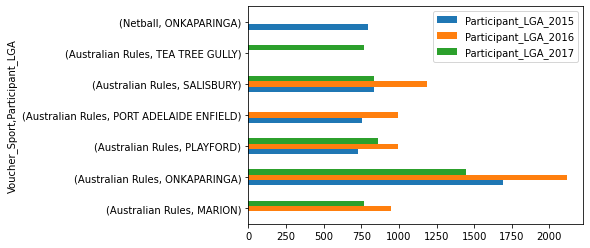

In [41]:
result_1 = pd.concat([a,b,c], join = 'outer', axis = 1)  #concatenating 3 dataframes
result_1.plot(kind='barh')
plt.legend(['Participant_LGA_2015','Participant_LGA_2016','Participant_LGA_2017'])

The above graph represents top 5 Participant_LGA with Voucher_sport for years 2015, 2016 and 2017 represented by different colors.

In [42]:
grouped_2 = sa_vouchers.groupby(sa_vouchers.Voucher_Value)
for Voucher_Value, Voucher_Value_sa_vouchers in grouped_2:
    print(Voucher_Value)
g10 = grouped_2.get_group(5)
print('size of Voucher value 5',g10.shape)
print('voucher value 5 claiming year',g10.Voucher_Claim_Year)

5
10
13
15
20
25
27
30
31
32
34
35
39
40
41
45
49
50
size of Voucher value 5 (14, 13)
voucher value 5 claiming year 21673     2015
62584     2015
62586     2015
62588     2015
62592     2015
62597     2015
62607     2015
86817     2015
86821     2015
109424    2015
109425    2015
109446    2015
109547    2015
109570    2015
Name: Voucher_Claim_Year, dtype: int64


The minimum voucher value is 5 and max is 50. And there are 14 participants who have voucher value of 5 and all of them redeemed the voucher in the year 2015. 

In [43]:
q1 = sa_vouchers['Participant_LGA'].value_counts()
print('Participant_LGA with smallest no. of participants',q1.nsmallest(5))
print('Participant_LGA with smallest no. of participants',q1.nlargest(5))

Participant_LGA with smallest no. of participants COOBER PEDY           39
PETERBOROUGH          45
FLINDERS RANGES      102
ORROROO/CARRIETON    137
FRANKLIN HARBOUR     155
Name: Participant_LGA, dtype: int64
Participant_LGA with smallest no. of participants ONKAPARINGA       12782
SALISBURY          8169
TEA TREE GULLY     7219
PLAYFORD           6940
CHARLES STURT      6897
Name: Participant_LGA, dtype: int64


The lowest number of participants are from COOBER PEDY LGA. And the largest number of participants are from ONKAPARINGA.

The above answer completes Question 1.

<AxesSubplot:ylabel='Voucher_Sport,Participant_LGA'>

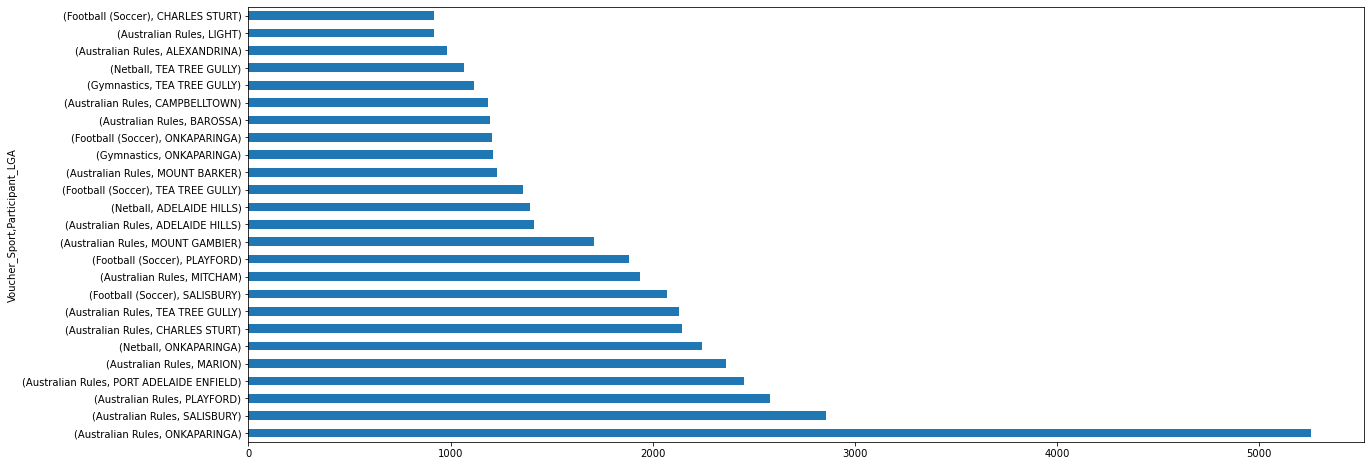

In [44]:
ga = sa_vouchers_scores.groupby(['Voucher_Sport'], sort=False)['Participant_LGA'].value_counts() 
gd = ga.nlargest(25)
gd.plot(kind='barh',figsize=(20, 8))

Above is the graph of top most Voucher_Sport with maximum number of participants from the particular state or LGA. And from the graph it is clearly visible that Australian Rules is the most popular game in most of the LGA

The above answer completes Question 2.

In [45]:
count = sa_vouchers_scores.shape[0]

Text(0, 0.5, 'Participant_LGA')

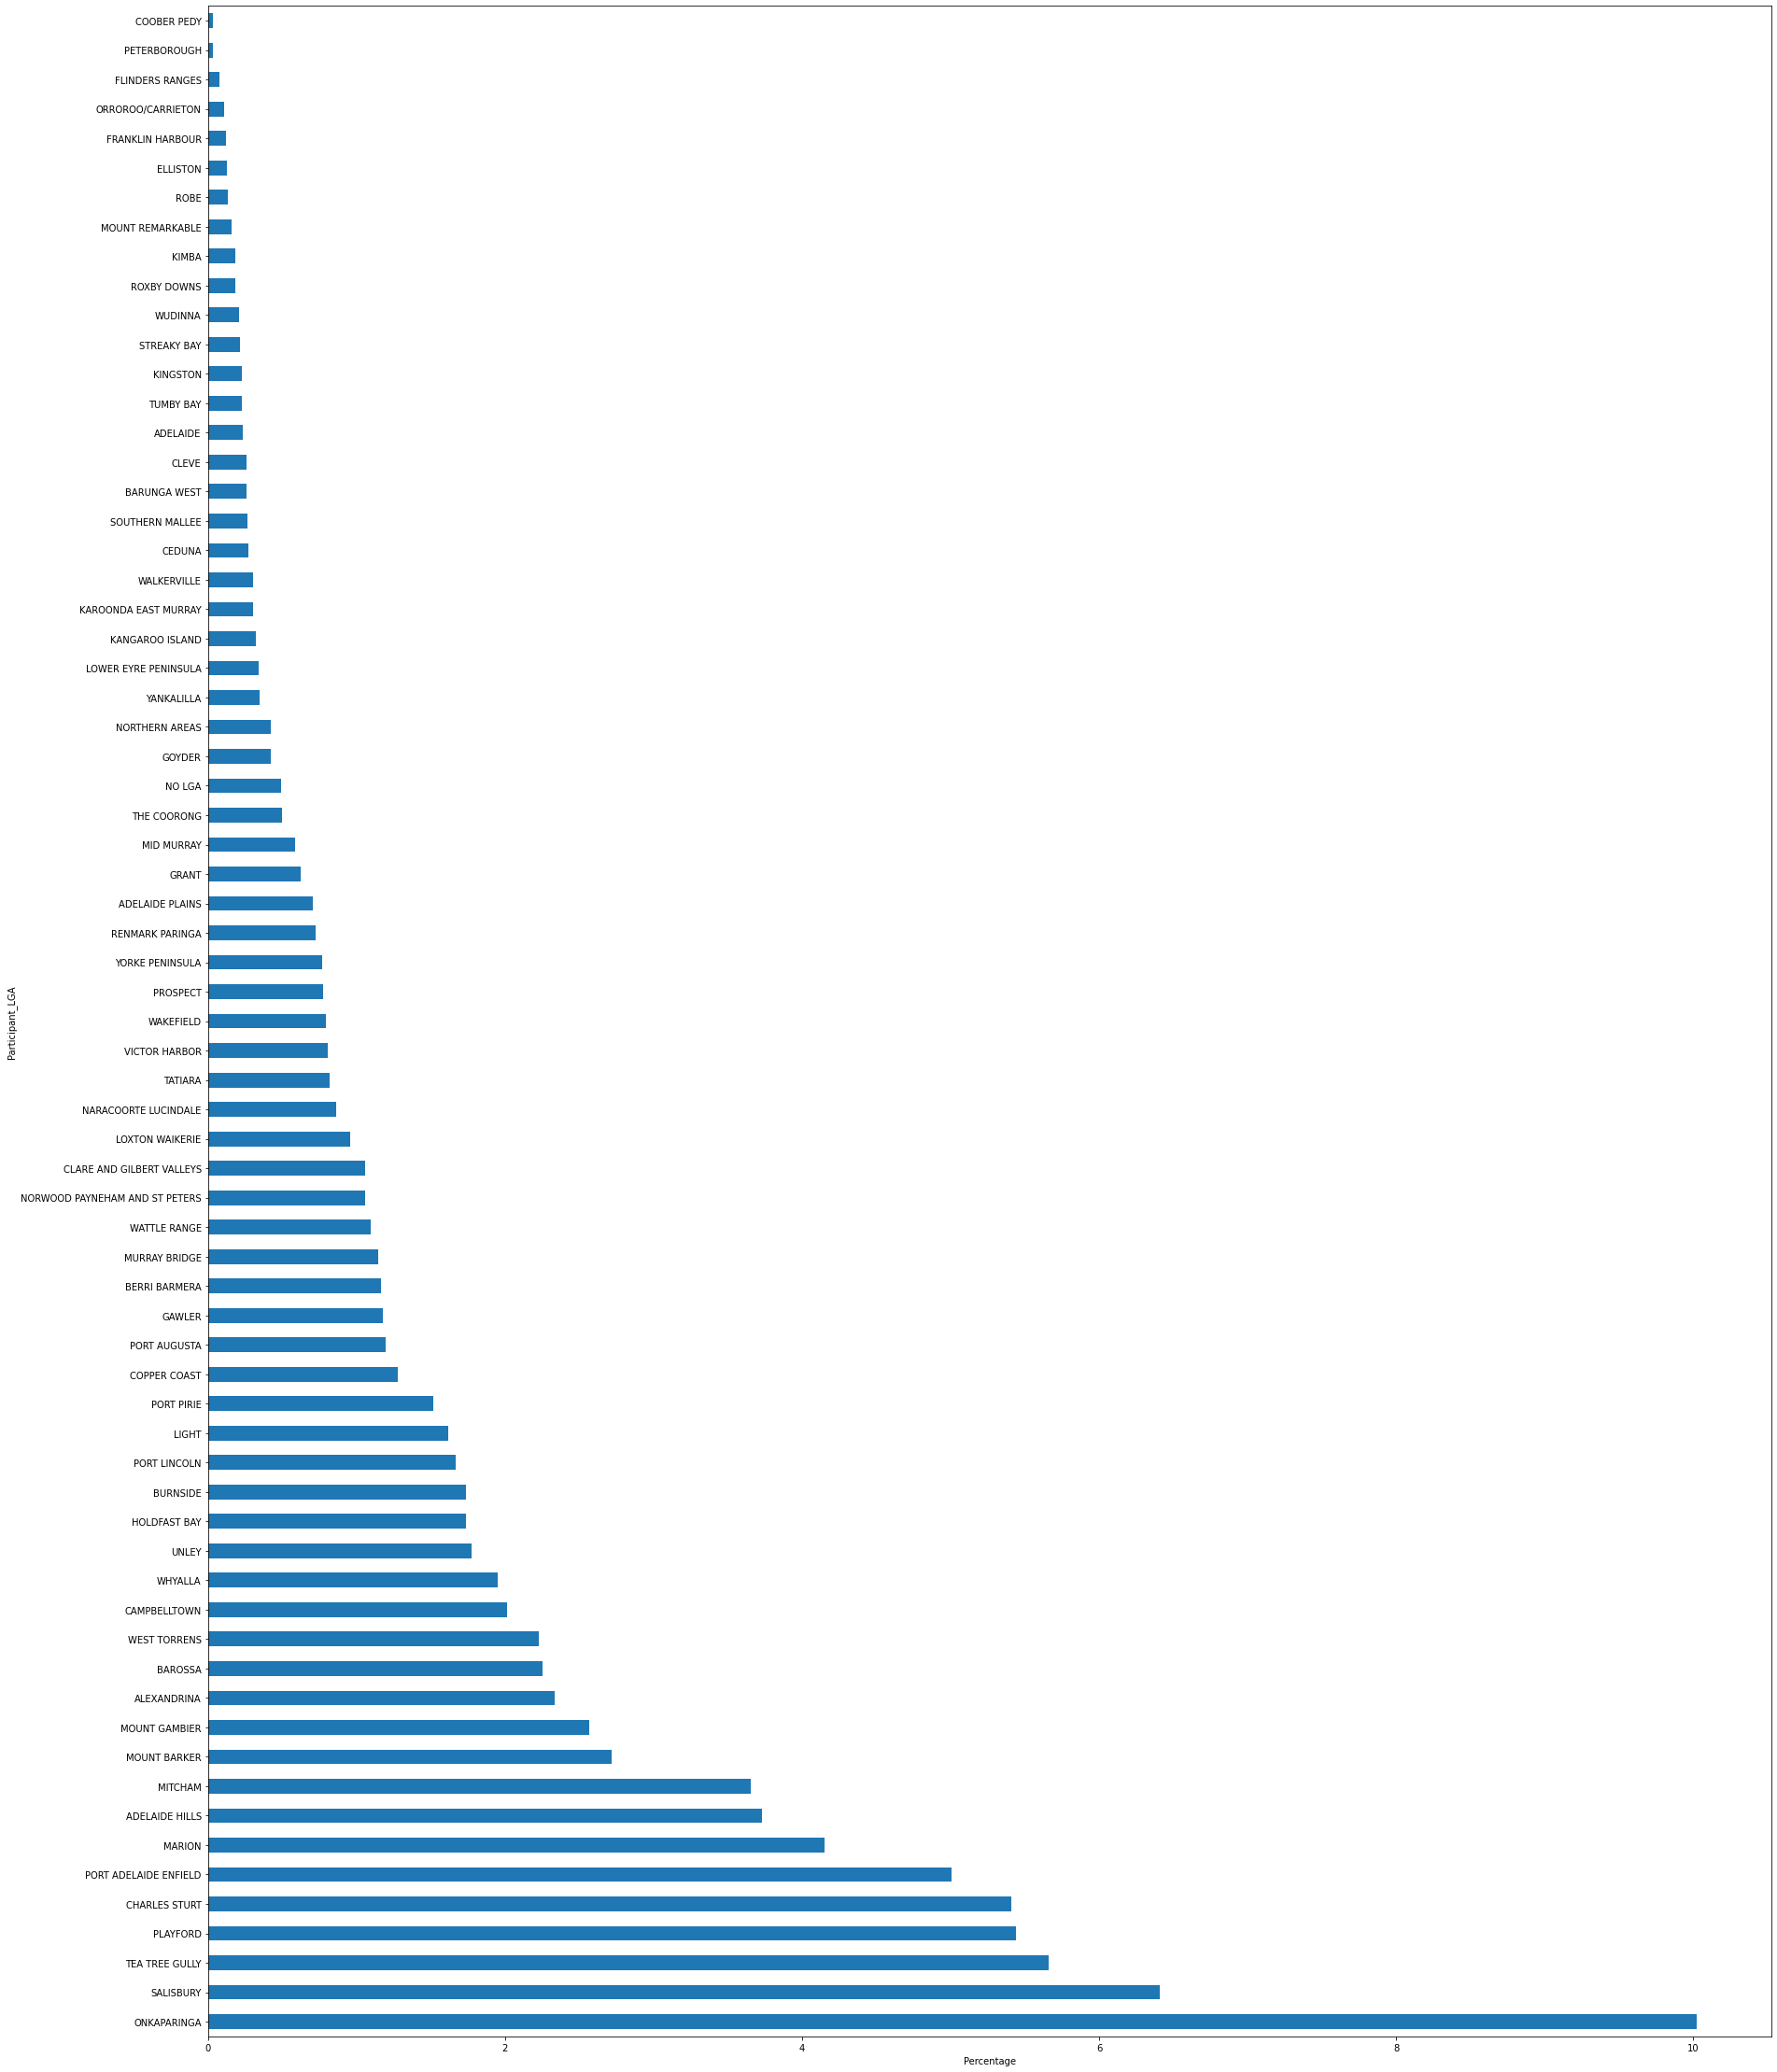

In [46]:
perc = sa_vouchers_scores.Participant_LGA.value_counts()/count*100
perc.plot(kind='barh',figsize=(30, 40))
plt.xlabel('Percentage')
plt.ylabel('Participant_LGA')

Above is the graph which shows the distribution of Participant_LGA. X axis contains the name of Participant_LGA and y axis contains the percentage of all Participant_LGA's. So, from the above graph, it is evident that ONKAPARINGA has the highest percentage which means that ONKAPARINGA was issued the maximum number of vouchers.

The above answer completes Question 3.

In [47]:
a1 = (LGA_scores.dropna())
a1.head()

#dropping all the NA values

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [53]:
LGA_scores['vouchersclaimed'] = sa_vouchers_scores.groupby('Participant_LGA').count()
LGA_scores.head()

# making a new column to know vouchers claimed in each LGA

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population,vouchersclaimed
LGA,,,,,,
ADELAIDE,874,874,1036,1013,19606,302.0
ADELAIDE HILLS,1083,1083,1077,1081,38601,4756.0
ALEXANDRINA,1000,1000,969,987,23693,2979.0
ANANGU PITJANTJATJARA,623,623,672,593,2433,NaN
BAROSSA,1028,1028,997,1017,22174,2874.0


In [55]:
a1 = (LGA_scores.dropna())
a1.head()

#dropping all the NA values

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population,vouchersclaimed
LGA,,,,,,
ADELAIDE,874,874,1036,1013,19606,302.0
ADELAIDE HILLS,1083,1083,1077,1081,38601,4756.0
ALEXANDRINA,1000,1000,969,987,23693,2979.0
BAROSSA,1028,1028,997,1017,22174,2874.0
BARUNGA WEST,981,981,940,954,2467,333.0


In [56]:
w1 = a1[['vouchersclaimed','IEO','IER','IRSAD','IRSD']]
w1.corr(method ='pearson')

# creating a correlation table

INDEX_TYPE,vouchersclaimed,IEO,IER,IRSAD,IRSD
INDEX_TYPE,,,,,
vouchersclaimed,1.000000,0.004747,0.004747,0.054572,0.034751
IEO,0.004747,1.000000,1.000000,0.778839,0.846423
IER,0.004747,1.000000,1.000000,0.778839,0.846423
IRSAD,0.054572,0.778839,0.778839,1.000000,0.985035
IRSD,0.034751,0.846423,0.846423,0.985035,1.000000


The above table shows the pairwise correlation between all columns in the dataframe. The above table represents the relationship between total vouchers claimed in each LGA and SEIFA measures. IEO which stands for Index of Education and Occupation has a positive correlation with vouchers claimed. IEO reflects the educational and occupational level of communities and positive correlation implies that IEO level of a community becomes less, fewer participants in the community claim their vouchers.
IER which measures economic resources of a community has a positive correlation with vouchers claimed. IER focuses on the financial aspects of relative socio-economic advantage and disadvantage, by summarising variables related to income and wealth and positive correlation implies that as the IER level of a community becomes less, participants in the same tend to claim less vouchers.
IRSAD which stands for Index of Relative Socio-Economic Advantage and Disadvantage has a positive correlation with vouchers claimed. IRSAD summarises information about the economic and social conditions of people and households within an area, including both relative advantage and disadvantage measures and positive correlation implies that as the IRSAD level becomes less, majority of participants in a community belong to socio-economic disadvantaged group and claim less vouchers.
IRSD which stands for Index of Relative Socio-economic Disadvantage has a positive correlation with vouchers claimed. IRSD summarises a range of information about the economic and social conditions of people and households within an area, and it includes only disadvantage measures and positive correlation implies that as the IRSD level becomes less, majority of participants in a community belong to socio-economic disadvantaged group and claim less vouchers.
Although correlation signs are expected, none of the SEIFA measures seem to have significant positive correlation with number of vouchers claimed.  

The above answer completes Question 4.

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [57]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00


In [83]:
seifa_1 = pd.read_csv('files/ABS_SEIFA_LGA.csv')
seifa_1 = seifa_1[seifa_1.LGA_2011.astype(str).str[0] == '3']
lga = seifa_1["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa_1['LGA'] = lga
seifa_1.head()
LGA_scores_1 = seifa_1[seifa_1.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores_1.head()
LGA_pop = seifa_1[seifa_1.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores_1['Population'] = LGA_pop.IEO
LGA_scores_1.head()

# making a pivot table using SEIFA dataset for only Queensland data.

<ipython-input-83-55b133f84d98>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  lga = seifa_1["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()


INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
AURUKUN,521,521,586,483,1292
BALONNE,973,973,950,959,4719
BANANA,1017,1017,980,997,14451
BARCALDINE,998,998,974,992,3217
BARCOO,989,989,947,953,352


In [84]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores_1, on='LGA')
qld_vouchers_scores.head()

<ipython-input-84-8b5046720010>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()


,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,989.0,989.0,966.0,982.0,31393.0
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0


In [85]:
dict_2 = {'BMX Bicycle Motocross': "BMX",
          "Bowls Lawn": "Bowls",
          "Pony Club": "Pony Clubs", '*Other':'*Other','Archery':'Archery','Australian Football':'Australian Rules'
          ,'Baseball':'Baseball','Basketball':'Basketball','Body Boarding':'Body Boarding','Boxing':'Boxing',
          'Broomball':'Broomball','Bushwalking':'Bushwalking','Calisthenics':'Calisthenics',
          'Canoeing Outrigger':'Canoeing Outrigger','Cheerleading':'Cheerleading','Cricket':'Cricket',
          'Cycling':'Cycling','Dancesport':'Dancesport','Disability Sports':'Disability Sports',
          'Dragon Boating':'Dragon Boating','Equestrian':'Equestrian','Football (Soccer)':'Football (Soccer)',
          'Futsal':'Futsal','Golf':'Golf','Gymnastics':'Gymnastics','Hockey':'Hockey','Ice Hockey':'Ice Hockey',
          'Ice Skating':'Ice Skating','Inline Hockey':'Inline Hockey', 'Ju Jitsu':'Ju Jitsu','Judo':'Judo',
          'Karate':'Karate', 'Karting':'Karting','Kayaking':'Kayaking','Life Saving Surf':'Life Saving Surf',
          'Mixed Martial Arts':'Mixed Martial Arts','Motor Cycling':'Motor Cycling','Netball':'Netball',
          'Oztag':'Oztag','Parkour':'Parkour','Polocrosse':'Polocrosse','Riding for the Disabled':'Riding for the Disabled',
          'Roller Sports':'Roller Sports','Rowing':'Rowing','Rugby League':'Rugby League','Rugby Union':'Rugby Union',
          'Sailing':'Sailing','Shooting':'Shooting','Skipping':'Skipping','Softball':'Softball',
          'Squash':'Squash','Surfing':'Surfing','Swimming':'Swimming','Swimming Synchronised':'Swimming Synchronised',
          'T-Ball':'T-Ball','Table Tennis':'Table Tennis','Taekwondo':'Taekwondo','Tennis':'Tennis',
          'Tenpin Bowling':'Tenpin Bowling','Touch':'Touch','Trail Bike Riding':'Trail Bike Riding',
          'Trampolining':'Trampolining','Weightlifting':'Weightlifting','Zen Do Kai Martial Arts':'Zen Do Kai Martial Arts',
          'Athletics':'Athletics','Rock Climbing':'Rock Climbing'}
qld_vouchers_scores["Participation_Activity"] = qld_vouchers_scores["Participation Activity"].map(dict_2)

# mapping the queensland dataset with respect to south australia dataset.

In [86]:
qld_vouchers_scores = qld_vouchers_scores.drop(['Participation Activity'], axis = 1)
qld_vouchers_scores.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population,Participation_Activity
0,2000012253,Q89QDUXP,10,NaN,Yes,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,989.0,989.0,966.0,982.0,31393.0,*Other
1,2000001727,593F6Y41,5,NaN,No,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0,*Other
2,2000013464,PH2R4RTT,5,NaN,No,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0,*Other
3,2000009270,035SE2H5,5,NaN,Yes,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0,*Other
4,2000007273,NP6C4729,6,NaN,No,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0,*Other


In [87]:
p1 = qld_vouchers_scores['LGA'].value_counts()
comp_1 = p1.nlargest(5)
comp_1

GOLD COAST        1700
BRISBANE          1425
SUNSHINE COAST     974
MORETON BAY        938
LOGAN              805
Name: LGA, dtype: int64

In [88]:
comp_2 = q1.nlargest(5)
comp_2


ONKAPARINGA       12782
SALISBURY          8169
TEA TREE GULLY     7219
PLAYFORD           6940
CHARLES STURT      6897
Name: Participant_LGA, dtype: int64

Text(0, 0.5, 'Participant_LGA')

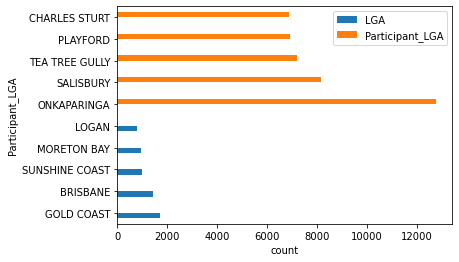

In [89]:
result = pd.concat([comp_1,comp_2], join = 'outer', axis = 1)
result.plot(kind='barh')
plt.xlabel('count')
plt.ylabel('Participant_LGA')

Above graph represents the comparison between top LGA's in both Queensland and South Australia dataset. In SA ONKAPARINGA contributed to the most number of participants whereas in Queensland GOLD COAST contributed to the most number of participants.

In [90]:
p2 = qld_vouchers_scores['Participation_Activity'].value_counts()
comp_3 = p2.nlargest(5)

In [91]:
p3 = sa_vouchers_scores['Voucher_Sport'].value_counts()
comp_4 = p3.nlargest(5)

Text(0, 0.5, 'Voucher_Sport')

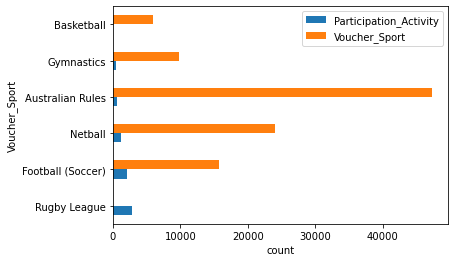

In [92]:
result_1 = pd.concat([comp_3,comp_4], join = 'outer', axis = 1)
result_1.plot(kind='barh')
plt.xlabel('count')
plt.ylabel('Voucher_Sport')

Above graph represents the comparison between top Voucher Sports/Participation Activity in both Queensland and South Australia dataset. In SA Australian Rules is very popular among the participants whereas in Queensland RUGBY LEAGUE is most popular sport.

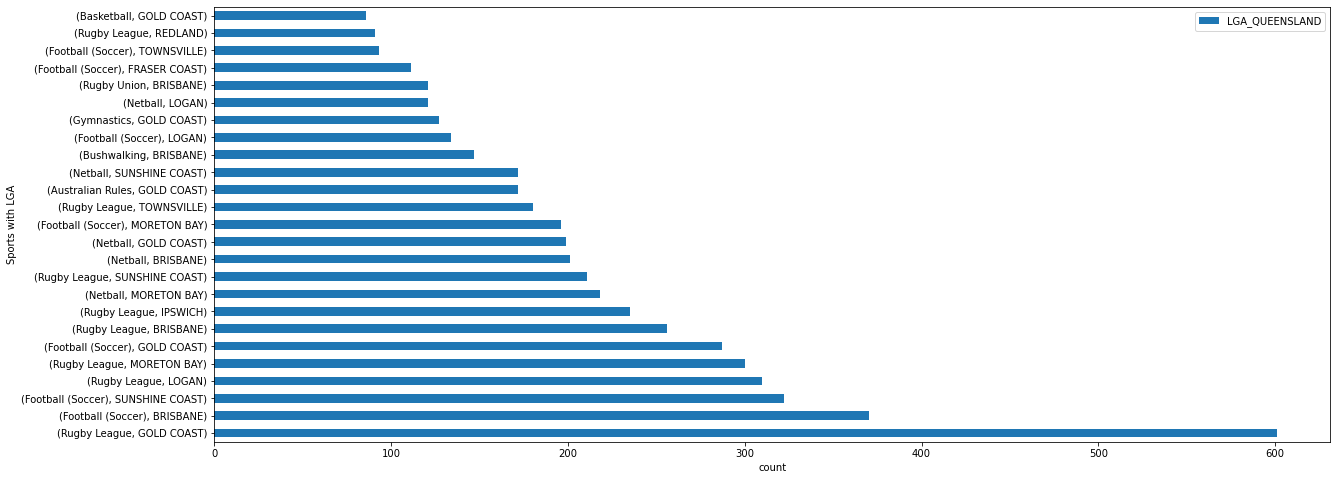

In [93]:
gc = qld_vouchers_scores.groupby(['Participation_Activity'], sort=False)['LGA'].value_counts() 
ge = gc.nlargest(25)
ge.plot(kind='barh',figsize=(20, 8))
plt.xlabel('count')
plt.ylabel('Sports with LGA')
plt.legend(['LGA_QUEENSLAND','LGA_SA'])


Above is the graph of top most Participant_Activity with maximum number of participants from the particular state or LGA. And from the graph it is clearly visible that in Queensland Rugby is the most popular game in most of the LGA's.

In [106]:
LGA_scores_1['vouchersclaimed'] = qld_vouchers_scores.groupby('LGA').count()
LGA_scores_1.head()

# making a new column to know vouchers claimed in each LGA

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population,vouchersclaimed
LGA,,,,,,
AURUKUN,521,521,586,483,1292,NaN
BALONNE,973,973,950,959,4719,NaN
BANANA,1017,1017,980,997,14451,NaN
BARCALDINE,998,998,974,992,3217,NaN
BARCOO,989,989,947,953,352,NaN


In [107]:
a2 = (LGA_scores_1.dropna())
a2.head()

#dropping all the NA values

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population,vouchersclaimed
LGA,,,,,,
BLACKALL TAMBO,981,981,945,961,2209,3.0
BRISBANE,1018,1018,1057,1048,1042074,1425.0
BUNDABERG,954,954,917,930,89786,116.0
CAIRNS,967,967,975,981,156176,266.0
CASSOWARY COAST,957,957,926,944,27676,42.0


In [110]:
w2 = a2[['vouchersclaimed','IEO','IER','IRSAD','IRSD']]
w2.corr(method ='pearson')

# creating a correlation table

INDEX_TYPE,vouchersclaimed,IEO,IER,IRSAD,IRSD
INDEX_TYPE,,,,,
vouchersclaimed,1.000000,0.223646,0.223646,0.455719,0.363639
IEO,0.223646,1.000000,1.000000,0.869487,0.877719
IER,0.223646,1.000000,1.000000,0.869487,0.877719
IRSAD,0.455719,0.869487,0.869487,1.000000,0.991002
IRSD,0.363639,0.877719,0.877719,0.991002,1.000000


The above table shows the pairwise correlation between all columns in the Queensland dataframe. The above table represents the relationship between total vouchers claimed in each LGA and SEIFA measures. IEO which stands for Index of Education and Occupation has a positive correlation with vouchers claimed. IEO reflects the educational and occupational level of communities and positive correlation implies that IEO level of a community becomes less, fewer participants in the community claim their vouchers.
IER which measures economic resources of a community has a positive correlation with vouchers claimed. IER focuses on the financial aspects of relative socio-economic advantage and disadvantage, by summarising variables related to income and wealth and positive correlation implies that as the IER level of a community becomes less, participants in the same tend to claim less vouchers.
IRSAD which stands for Index of Relative Socio-Economic Advantage and Disadvantage has a positive correlation with vouchers claimed. IRSAD summarises information about the economic and social conditions of people and households within an area, including both relative advantage and disadvantage measures and positive correlation implies that as the IRSAD level becomes less, majority of participants in a community belong to socio-economic disadvantaged group and claim less vouchers.
IRSD which stands for Index of Relative Socio-economic Disadvantage has a positive correlation with vouchers claimed. IRSD summarises a range of information about the economic and social conditions of people and households within an area, and it includes only disadvantage measures and positive correlation implies that as the IRSD level becomes less, majority of participants in a community belong to socio-economic disadvantaged group and claim less vouchers.
SEIFA measures seem to have a significant positive correlation with number of vouchers claimed. As, the correlation value lies between ± 0.30 and ± 0.49, it is said to be a medium correlation.
